In [459]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import time
import tracemalloc

## Dataset
Dataset was created using `sklearn.datasets.make_regression` with:

* `100` samples, `2` features
* `bias = 0`
* `noise ~ 0`
* each feature has equal `mean ~ 0` and standard `deviation ~ 1`

In [90]:
df = pd.read_csv("test_data.csv")
data = df.to_numpy()
data_y = data[:, data.shape[1] - 1]
data_x = data[:, 0:data.shape[1] - 1]
print('X:', data_x.shape, 'Y:', data_y.shape)
print('means:', data_x.mean(axis=0), 'deviations:', data_x.std(axis=0))

X: (100, 2) Y: (100,)
means: [1.22124533e-17 6.66133815e-18] deviations: [1. 1.]


## Gradient descent regressor with different optimizers
Solves `y = w * x + b`.
Actually, `x` is prepended with a column of ones. Therefore, bias is included in weights.

Regressor stores loss and weights update history.

In [538]:
class DefaultOptimizer:
    def __init__(self, lr=1e-4, reg=0.01):
        self.lr = lr
        self.reg = reg

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights) - batch_ys) / (batch_xs.shape[0])
        weights = weights - self.reg * weights * self.lr - self.lr * gradient
        return weights


class MomentumOptimizer:
    def __init__(self, lr=1e-4, gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.velocity = 0

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights) - batch_ys) / (batch_xs.shape[0])
        new_velocity = self.gamma * self.velocity + self.lr * gradient
        weights = weights - new_velocity
        self.velocity = new_velocity
        return weights

    
class NesterovOptimizer:
    def __init__(self, lr=1e-4, gamma=0.9):
        self.lr = lr
        self.gamma = gamma
        self.velocity = 0

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights - self.gamma * self.velocity) - batch_ys) / (batch_xs.shape[0])
        new_velocity = self.gamma * self.velocity + self.lr * gradient
        weights = weights - new_velocity
        self.velocity = new_velocity
        return weights


class AdaGradOptimizer:
    def __init__(self, lr=1e-4, eps=1e-8):
        self.lr = lr
        self.eps = eps
        self.g = 0

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights) - batch_ys) / (batch_xs.shape[0])
        self.g += gradient ** 2
        weights = weights - self.lr * gradient / np.sqrt(self.g + self.eps)
        return weights

    
class RMSPropOptimizer:
    def __init__(self, lr=1e-4, gamma=0.9, eps=1e-8):
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.g = 0

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights) - batch_ys) / (batch_xs.shape[0])
        self.g = (1 - self.gamma) * gradient ** 2 + self.g * self.gamma
        weights = weights - self.lr * gradient / np.sqrt(self.g + self.eps)
        return weights


class AdamOptimizer:
    def __init__(self, lr=1e-4, beta=0.9, gamma=0.99, eps=1e-8):
        self.lr = lr
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
        self.m = 0
        self.v = 0

    def optimize(self, batch_xs, batch_ys, weights):
        gradient = 2 * batch_xs.T.dot(batch_xs.dot(weights) - batch_ys) / (batch_xs.shape[0])
        self.m = self.beta * self.m + (1 - self.beta) * gradient
        self.v = self.gamma * self.v + (1 - self.gamma) * gradient ** 2
        weights = weights - self.lr * gradient / np.sqrt(self.v + self.eps)
        return weights    


class GDRegressor:
    def __init__(
        self,
        optimizer = DefaultOptimizer(),
        max_iter: int = 1000,
        batch_size: int = 1,
        epsilon: float = 1e-3,
        lambda_: float = 1e-1,
    ):
        self.optimizer = optimizer
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.weights_history = []
        self.loss_history = []
        self.iter_count = 0
        
    def fit(
        self,
        xs,
        ys,
        initial_weights = None,
        logging = True
    ):
        # Append column of ones --- bias
        xs = np.append(np.expand_dims(np.ones(xs.shape[0]), axis=1), xs, axis=1)
        
        # Initialize weights
        if initial_weights is None:
            weights = np.random.uniform(-1 / xs.shape[1], 1 / xs.shape[1], size=xs.shape[1])
        else:
            weights = initial_weights

        # Initialize functional (MSE - mean squared error?)
        q = np.mean((ys - xs.dot(weights)) ** 2)
        
        for i in range(self.max_iter):
            self.iter_count = i
            
            # Create a batch with a given size using random samples 
            batch_ids = np.random.choice(xs.shape[0], self.batch_size, replace=False)
            batch_xs, batch_ys = xs[batch_ids], ys[batch_ids]
            
            # Calculate epsilon
            hypothesis = batch_xs.dot(weights)
            error = np.mean((hypothesis - batch_ys) ** 2)
            
            # Update history
            if logging:
                self.weights_history.append(weights)
                self.loss_history.append(q)

            # Update weights
            weights = self.optimizer.optimize(batch_xs, batch_ys, weights)

            # Update functional
            q_ = q
            q = (1 - self.lambda_) * q_ + self.lambda_ * error
            
            # Stop criteria (can also have weights difference condition)
            if np.abs(q - q_) < self.epsilon:
                self.weights_history = np.array(self.weights_history)
                return self.loss_history
        
        self.weights_history = np.array(self.weights_history)
        return self.loss_history

In [95]:
def draw_contour_plot(gradient_descent, xs, ys, wx_range=(-10, 10), wy_range=(-10, 10), label=''):
    # Draws contour lines of the cost function and weights update path inside provided domain
    n = 200
    w0s = np.linspace(wx_range[0], wx_range[1], num=n)
    w1s = np.linspace(wy_range[0], wy_range[1], num=n)
    w_xs, w_ys = np.meshgrid(w0s, w1s)
    lambda_q = lambda i, j: np.mean((ys - xs.dot([w0s[i], w1s[j]]) - gradient_descent.weights_history[-1][0]) ** 2)
    q_vals = np.array([[lambda_q(i, j) for j in range(n)] for i in range(n)])

    plt.figure(figsize=(8, 8))
    cs = plt.contour(w_xs, w_ys, q_vals.T, 40)
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.title(label, fontsize=24)
    
    plt.plot(gradient_descent.weights_history[:, 1], gradient_descent.weights_history[:, 2], '-o', label=label)
    
    plt.show()

# Comparison of gradient descents with different batch sizes

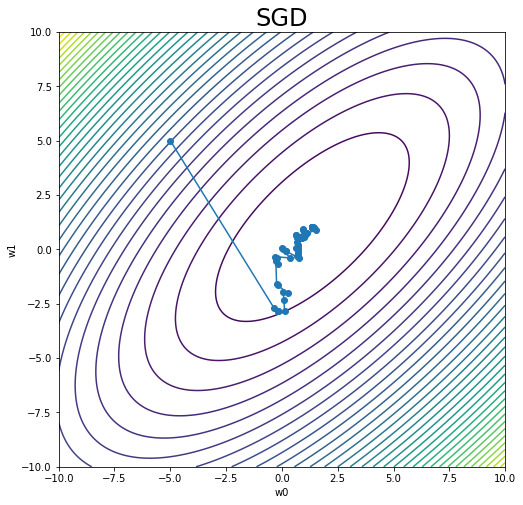

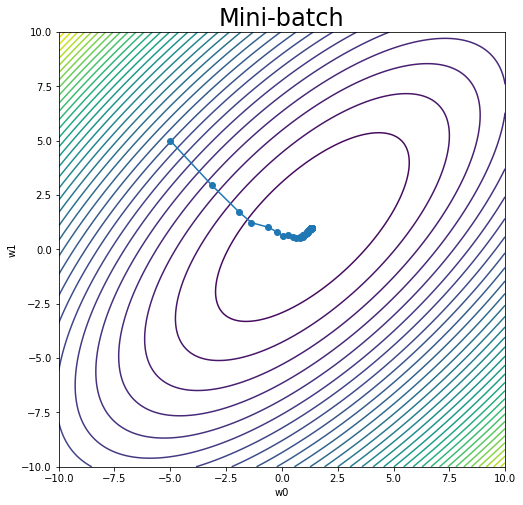

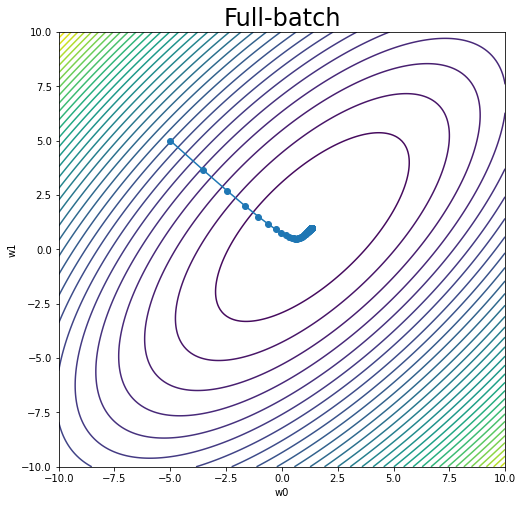

In [84]:
sgd_regressor = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=2e-1, optimizer=DefaultOptimizer(lr=0.08, reg=0.01))
mbgd_regressor = GDRegressor(batch_size=10, epsilon=1e-5, lambda_=2e-1, optimizer=DefaultOptimizer(lr=0.08, reg=0.01))
fbgd_regressor = GDRegressor(batch_size=99, epsilon=1e-5, lambda_=2e-1, optimizer=DefaultOptimizer(lr=0.08, reg=0.01))

initial_weights = np.array([0, -5, 5])
sgd_regressor.fit(data_x, data_y, initial_weights)
mbgd_regressor.fit(data_x, data_y, initial_weights)
fbgd_regressor.fit(data_x, data_y, initial_weights)

draw_contour_plot(sgd_regressor, data_x, data_y, label='SGD')
draw_contour_plot(mbgd_regressor, data_x, data_y, label='Mini-batch')
draw_contour_plot(fbgd_regressor, data_x, data_y, label='Full-batch')

In [105]:
print(f'SGD\nIterations: {len(sgd_regressor.loss_history)}, Loss: {sgd_regressor.loss_history[-1]}\n')
print(f'Minibatch\nIterations: {len(mbgd_regressor.loss_history)}, Loss: {mbgd_regressor.loss_history[-1]}\n')
print(f'GD\nIterations: {len(fbgd_regressor.loss_history)}, Loss: {fbgd_regressor.loss_history[-1]}')

SGD
Iterations: 100, Loss: 0.00011877726509335362

Minibatch
Iterations: 98, Loss: 0.00046386589621969475

GD
Iterations: 107, Loss: 0.0003858556005942767


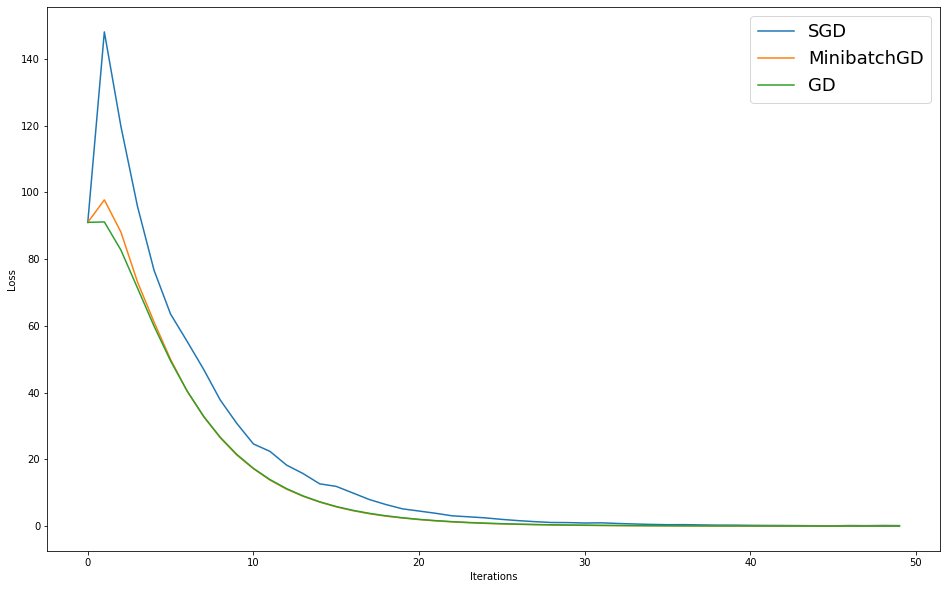

In [96]:
plt.figure(figsize=(16, 10))
plt.plot(sgd_regressor.loss_history[:50], label='SGD')
plt.plot(mbgd_regressor.loss_history[:50], label='MinibatchGD')
plt.plot(fbgd_regressor.loss_history[:50], label='GD')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(fontsize=18)
plt.show()

# How feature scaling affects gradient descent
Previous dataset was already "good". Let's inspect another synthetic dataset.

It consists of 2 independent variables `x1` and `x2`, and one dependent variable `y = 2 * x1 + 0.013 * x2`

In [112]:
df = pd.read_csv("scaling.csv")
data = df.to_numpy()
ys = data[:, data.shape[1] - 1]
xs = data[:, 0:data.shape[1] - 1]
print('X:', xs.shape, 'Y:', ys.shape)
print('means:', xs.mean(axis=0), 'deviations:', xs.std(axis=0))

X: (399, 2) Y: (399,)
means: [  5.01253133 501.25313283] deviations: [  3.02833232 302.83323242]


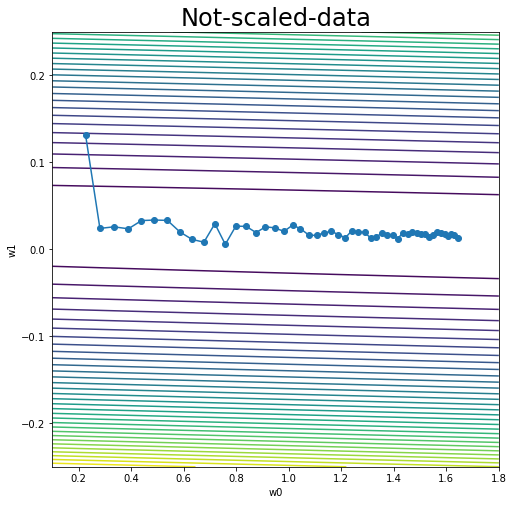

In [177]:
bad_regressor = GDRegressor(batch_size=1, epsilon=1e-8, max_iter=50000, lambda_=5e-1, optimizer=DefaultOptimizer(lr=0.000001))
bad_regressor.fit(xs, ys)
bad_regressor.weights_history = bad_regressor.weights_history[0::1000]
draw_contour_plot(bad_regressor, xs, ys, (0.1, 1.8), (-0.25, 0.25), label='Not-scaled-data')

In [119]:
# Applying Z-Score Normalization
means = xs.mean(axis=0)
deviations = xs.std(axis=0)
xs_scaled = (xs - means) / deviations
print('means:', xs_scaled.mean(axis=0), 'deviations:', xs_scaled.std(axis=0))

means: [ 3.56161772e-17 -2.13697063e-16] deviations: [1. 1.]


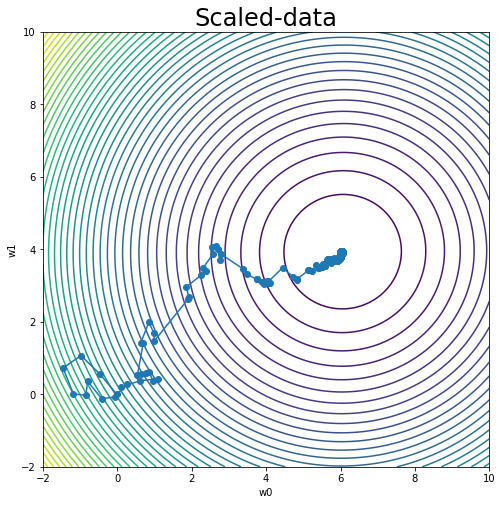

In [178]:
good_regressor = GDRegressor(batch_size=1, epsilon=1e-8, max_iter=1000, lambda_=5e-1, optimizer=DefaultOptimizer(lr=0.02))
good_regressor.fit(xs_scaled, ys)
draw_contour_plot(good_regressor, xs_scaled, ys, (-2, 10), (-2, 10), label='Scaled-data')

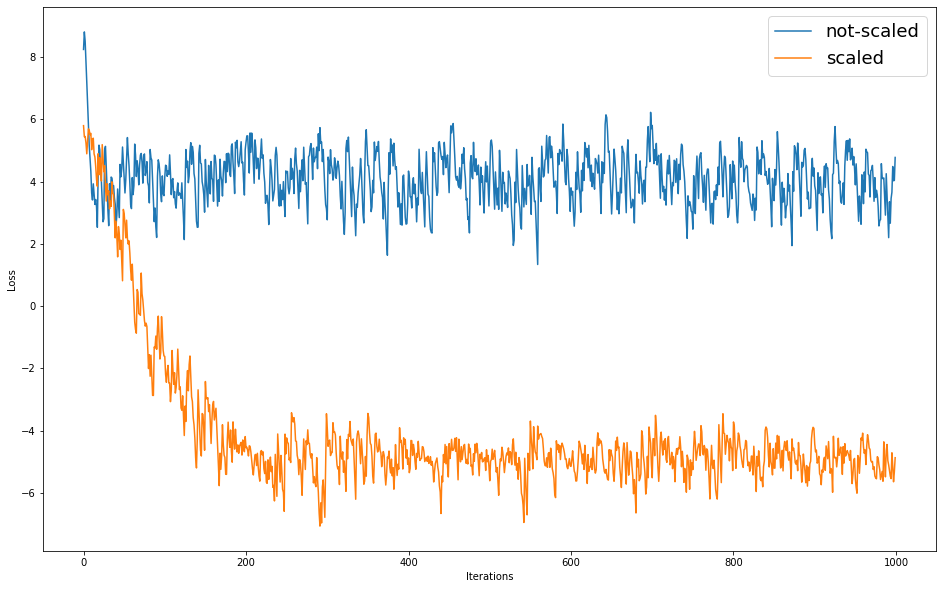

In [471]:
plt.figure(figsize=(16, 10))
plt.plot(np.log(bad_regressor.loss_history[:1000]), label='not-scaled')
plt.plot(np.log(good_regressor.loss_history[:1000]), label='scaled')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(fontsize=18)
plt.show()

# Gradient descent modifications 

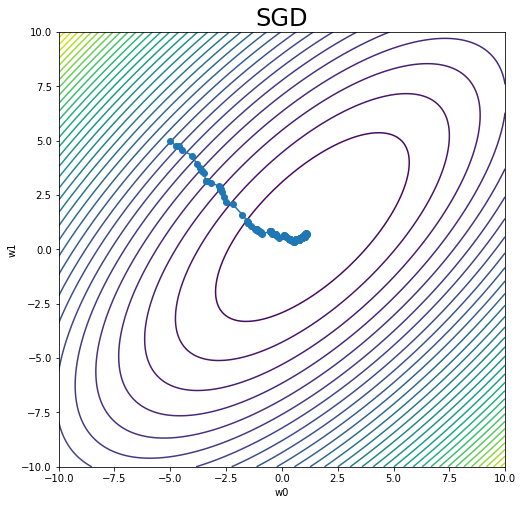

In [181]:
sgd_default = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=DefaultOptimizer(lr=0.01, reg=0.01))
sgd_default_losses = sgd_default.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_default, data_x, data_y, label='SGD')

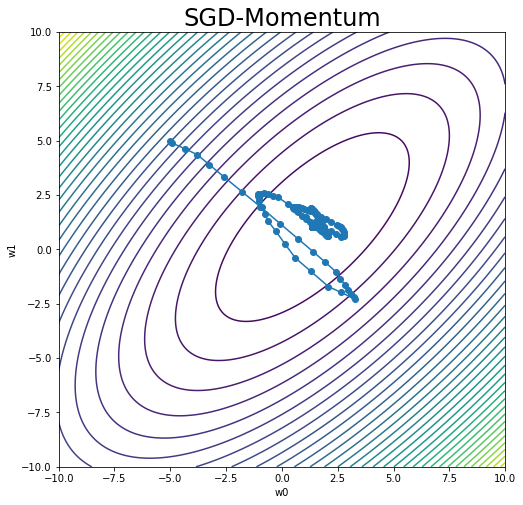

In [465]:
sgd_momentum = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=MomentumOptimizer(lr=0.01))
sgd_momentum_losses = sgd_momentum.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_momentum, data_x, data_y, label='SGD-Momentum')

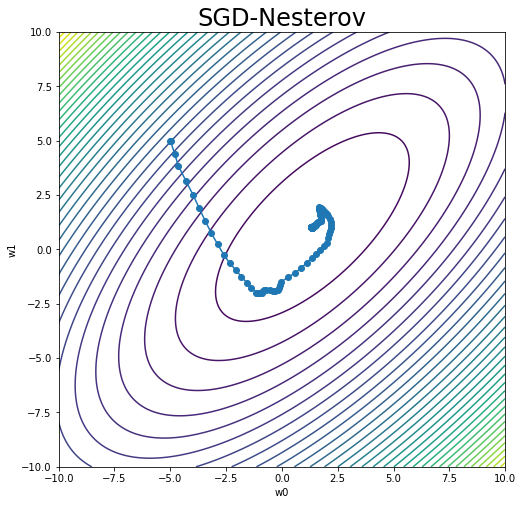

In [469]:
sgd_nesterov = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=NesterovOptimizer(lr=0.01))
sgd_nesterov_losses = sgd_nesterov.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_nesterov, data_x, data_y, label='SGD-Nesterov')

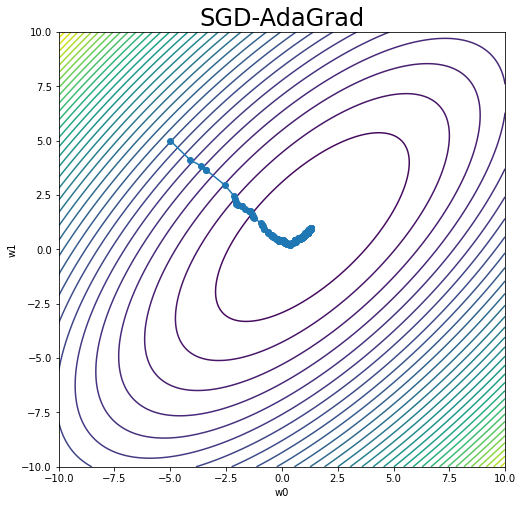

In [196]:
sgd_adagrad = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdaGradOptimizer(lr=9e-1))
sgd_adagrad_losses = sgd_adagrad.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_adagrad, data_x, data_y, label='SGD-AdaGrad')

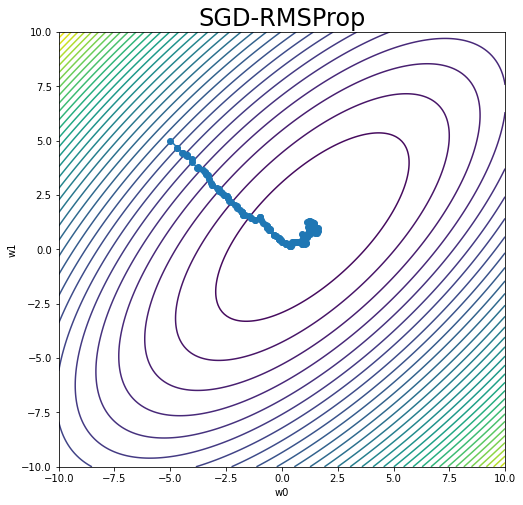

In [197]:
sgd_rmsprop = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=RMSPropOptimizer(lr=1e-1))
sgd_rmsprop_losses = sgd_rmsprop.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_rmsprop, data_x, data_y, label='SGD-RMSProp')

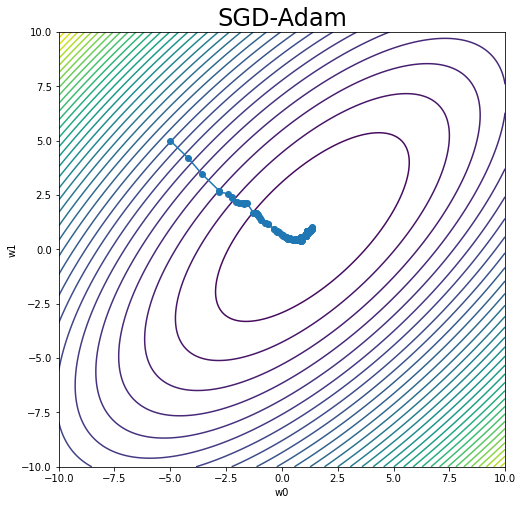

In [198]:
sgd_adam = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdamOptimizer(lr=8e-2))
sgd_adam_losses = sgd_adam.fit(data_x, data_y, np.array([0, -5, 5]))
draw_contour_plot(sgd_adam, data_x, data_y, label='SGD-Adam')

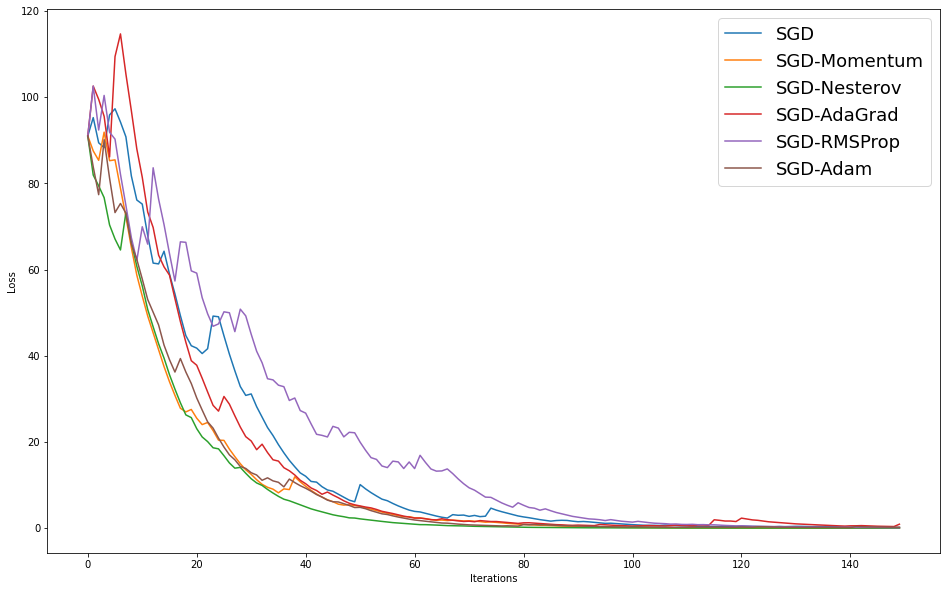

In [199]:
plt.figure(figsize=(16, 10))
plt.plot(sgd_default_losses[:150], label='SGD')
plt.plot(sgd_momentum_losses[:150], label='SGD-Momentum')
plt.plot(sgd_nesterov_losses[:150], label='SGD-Nesterov')
plt.plot(sgd_adagrad_losses[:150], label='SGD-AdaGrad')
plt.plot(sgd_rmsprop_losses[:150], label='SGD-RMSProp')
plt.plot(sgd_adam_losses[:150], label='SGD-Adam')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(fontsize=18)
plt.show()

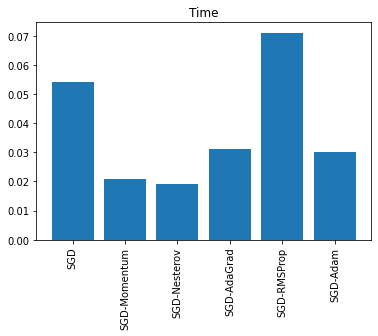

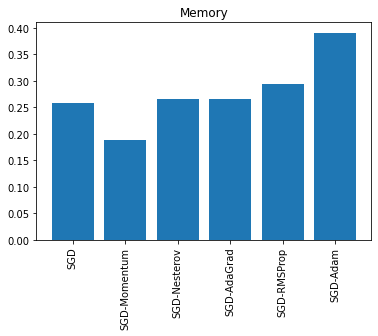

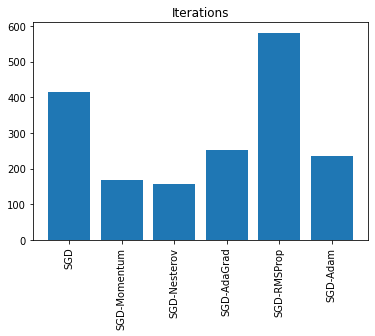

{'SGD': [0.05401253700256348, 0.2578125, 416],
 'SGD-Momentum': [0.021004438400268555, 0.1875, 168],
 'SGD-Nesterov': [0.019004344940185547, 0.265625, 157],
 'SGD-AdaGrad': [0.031007051467895508, 0.265625, 252],
 'SGD-RMSProp': [0.07101607322692871, 0.29296875, 581],
 'SGD-Adam': [0.03000664710998535, 0.390625, 234]}

In [542]:
regressors = {
    'SGD': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=DefaultOptimizer(lr=0.01, reg=0.01)),
    'SGD-Momentum': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=MomentumOptimizer(lr=0.01)),
    'SGD-Nesterov': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=NesterovOptimizer(lr=0.01)),
    'SGD-AdaGrad': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdaGradOptimizer(lr=9e-1)),
    'SGD-RMSProp': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=RMSPropOptimizer(lr=1e-1)),
    'SGD-Adam': GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdamOptimizer(lr=8e-2)),
}

stats = {}


for key in regressors:
    regressor = regressors[key]
    
    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()

    start = time.time()
    regressor.fit(data_x, data_y, np.array([0, -5, 5]), logging=False)
    end = time.time()

    snapshot2 = tracemalloc.take_snapshot()
    tracemalloc.stop()
    
    duration = end - start
    iterations = regressor.iter_count
    memory = 0
    top_stats = snapshot2.compare_to(snapshot1, 'lineno')
    for stat in top_stats[:10]:
        if 'ipykernel' in str(stat.traceback):
            memory += stat.size_diff
    
    stats[key] = [duration, memory / 1024, iterations]


names = [label for label in regressors]

plt.title('Time')
plt.bar(names, [stats[key][0] for key in regressors])
plt.xticks(rotation='vertical')
plt.show()

plt.title('Memory')
plt.bar(names, [stats[key][1] for key in regressors])
plt.xticks(rotation='vertical')
plt.show()

plt.title('Iterations')
plt.bar(names, [stats[key][2] for key in regressors])
plt.xticks(rotation='vertical')
plt.show()

stats

# Usefull stuff

In [ ]:
# Create regressions
X, Y, real_w = make_regression(n_samples=200, n_features=2, n_informative=2, noise=0.0, coef=True, effective_rank=1,
                               tail_strength=0.1, bias=5)
X = scale(X)
Y = scale(Y)

In [ ]:
# Save to csv
to_save = np.append(xs, np.expand_dims(ys, axis=1), axis=1)

df = pd.DataFrame(to_save, columns = ['x1','x2','y'])
df.to_csv('test_data.csv', index=False)

In [ ]:
# sklearn regressor
from sklearn.linear_model import SGDRegressor
reg = SGDRegressor(max_iter=50000, tol=1e-5)
reg.fit(X, Y)
print(reg.coef_, reg.intercept_)
X.mean()

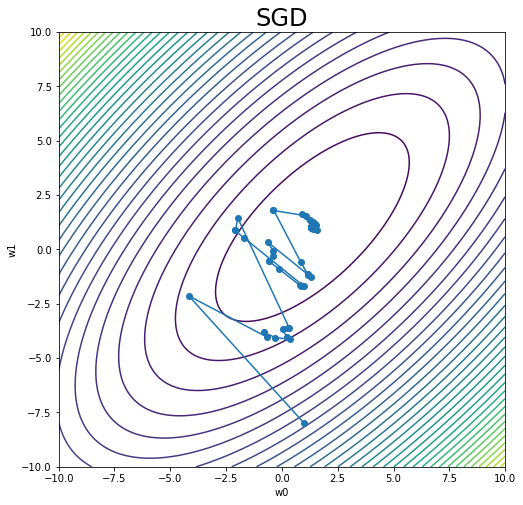

In [481]:
sgd_default = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=DefaultOptimizer(lr=0.15, reg=0.01))
sgd_default_losses = sgd_default.fit(data_x, data_y, np.array([0, 1, -8]))
draw_contour_plot(sgd_default, data_x, data_y, label='SGD')

In [529]:
def draw_contour_plots(regressors, xs, ys, wx_range=(-10, 10), wy_range=(-10, 10), labels=[]):
    # Draws contour lines of the cost function and weights update path inside provided domain
    n = 200
    w0s = np.linspace(wx_range[0], wx_range[1], num=n)
    w1s = np.linspace(wy_range[0], wy_range[1], num=n)
    w_xs, w_ys = np.meshgrid(w0s, w1s)
    
    b = regressors[0].weights_history[-1][0]
    lambda_q = lambda i, j: np.mean((ys - xs.dot([w0s[i], w1s[j]]) - b) ** 2)
    q_vals = np.array([[lambda_q(i, j) for j in range(n)] for i in range(n)])

    plt.figure(figsize=(16, 16))
    cs = plt.contour(w_xs, w_ys, q_vals.T, 40)
    plt.xlabel('w0')
    plt.ylabel('w1')
    
    for regressor, label in zip(regressors, labels):
        plt.plot(regressor.weights_history[:, 1], regressor.weights_history[:, 2], '--', label=label)
    
    plt.legend(fontsize=24)
    plt.show()

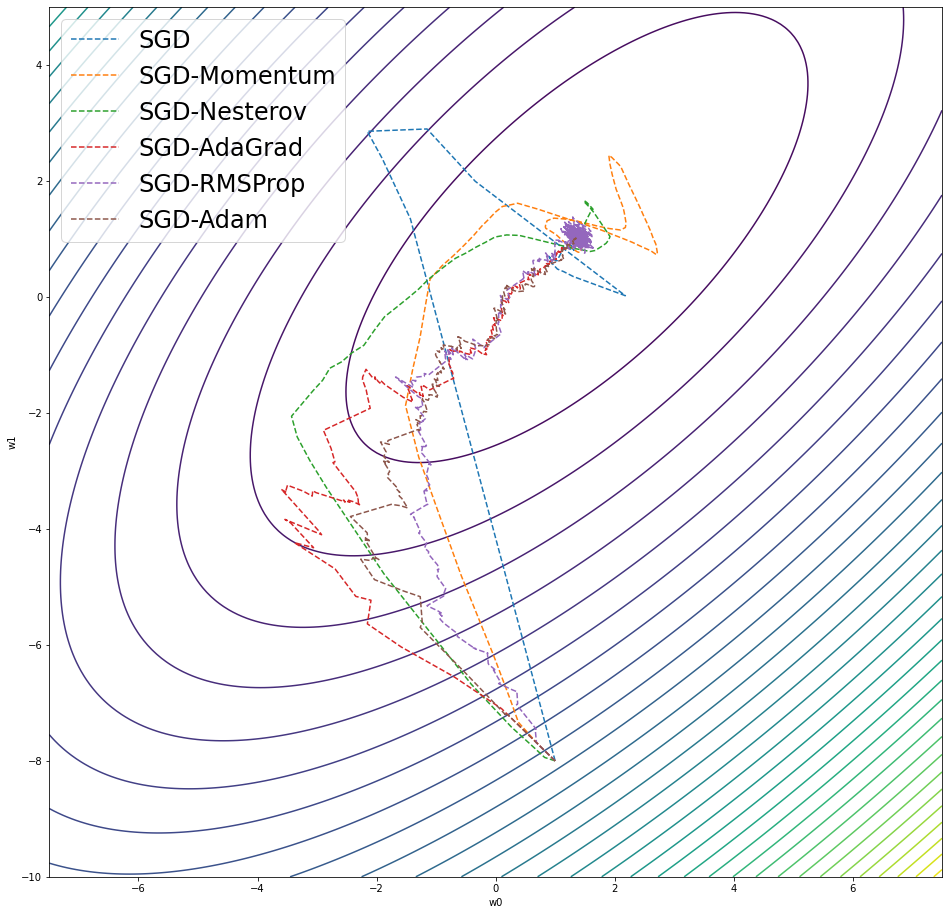

In [532]:
sgd_default = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=DefaultOptimizer(lr=0.15, reg=0.01))
sgd_default_losses = sgd_default.fit(data_x, data_y, np.array([0, 1, -8]))

sgd_momentum = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=MomentumOptimizer(lr=0.01))
sgd_momentum_losses = sgd_momentum.fit(data_x, data_y, np.array([0, 1, -8]))

sgd_nesterov = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=NesterovOptimizer(lr=0.01))
sgd_nesterov_losses = sgd_nesterov.fit(data_x, data_y, np.array([0, 1, -8]))

sgd_adagrad = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdaGradOptimizer(lr=9e-1))
sgd_adagrad_losses = sgd_adagrad.fit(data_x, data_y, np.array([0, 1, -8]))

sgd_rmsprop = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=RMSPropOptimizer(lr=1e-1))
sgd_rmsprop_losses = sgd_rmsprop.fit(data_x, data_y, np.array([0, 1, -8]))

sgd_adam = GDRegressor(batch_size=1, epsilon=1e-5, lambda_=1e-1, optimizer=AdamOptimizer(lr=8e-2))
sgd_adam_losses = sgd_adam.fit(data_x, data_y, np.array([0, 1, -8]))

labels = ['SGD', 'SGD-Momentum', 'SGD-Nesterov', 'SGD-AdaGrad', 'SGD-RMSProp', 'SGD-Adam']
regressors = [sgd_default, sgd_momentum, sgd_nesterov, sgd_adagrad, sgd_rmsprop, sgd_adam]

draw_contour_plots(regressors, data_x, data_y, wx_range=(-7.5, 7.5), wy_range=(-10, 5), labels=labels)